# RL LunarLanding: Actor-Critic A2S  with Pytorch

In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque, namedtuple
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
cpu_count = os.cpu_count()
print(f"CPU count: {cpu_count}")
torch.set_num_threads(cpu_count)
print(f"PyTorch threads: {torch.get_num_threads()}")
print(f"PyTorch device: {device}")



CPU count: 12
PyTorch threads: 12
PyTorch device: cpu


In [50]:

# Environmental global variables:
SEED = 42

# Making the environment:
env = gym.make('LunarLander-v2')
#env = gym.make('CartPole-v1')
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
env.action_space.seed(SEED)  # Ensures deterministic action sampling

# Hyperparameters:
learning_rate = 0.005
gamma = 0.999
num_episodes = 20000
TAU = 0.1




# Defining the neural network:
space_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"Space_dim: {space_dim}, Action_dim: {action_dim}")



class Actor_Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor_Model, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        action_probabilities = F.softmax(self.fc3(state), dim=1)
        return action_probabilities
    
class Critic_Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic_Model, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)    
        self.fc3 = nn.Linear(64, 1)             # Output is a single value (V(s) value)

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        state_value = self.fc3(state)
        return state_value
    



# Defining the DQN Agent:
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.seed = random.seed(SEED)
        self.state_size = state_size
        self.action_size = action_size

        self.actor_nn = Actor_Model(state_size=state_size, action_size=action_size).to(device)
        self.critic_nn = Critic_Model(state_size=state_size, action_size=action_size).to(device)


        self.optimizer_critic = optim.Adam(self.critic_nn.parameters(), lr=learning_rate)
        self.optimizer_actor = optim.Adam(self.actor_nn.parameters(), lr=learning_rate)
        self.loss_fn_critic = nn.MSELoss()

        #self.memory = ReplayBuffer(replay_memory_capacity, action_size)
        self.t_step = 0
        self.tau = TAU
        self.gamma = gamma

  
    '''
    def choose_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action_probabilities = self.actor_nn(state)
        action = torch.multinomial(action_probabilities, num_samples=1).item()
        return action
    '''
    def choose_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_probs = self.actor_nn(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample().item()
        return action
    
    def compute_returns(self, rewards, dones, next_state):
        returns = []
        next_state_tensor = torch.from_numpy(next_state).float().unsqueeze(0).to(device)

        R = self.critic_nn(next_state_tensor)
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + (1 - done) * gamma * R
            returns.insert(0, R)
            
        # Convert returns to a PyTorch tensor, detach it, and then convert to numpy array
        returns_tensor = torch.tensor(returns, dtype=torch.float32)  # Convert list to tensor
        return returns_tensor.detach().numpy()  # Detach and convert to numpy

    def soft_update(self, target_model, local_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        with torch.no_grad():
            for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
                target_param.data.copy_(self.tau * local_param.data + (1 - self.tau) * target_param.data)

    def train(self, states, actions, returns):
        states_tensor = torch.from_numpy(np.array(states)).float().to(device)
        actions_tensor = torch.from_numpy(np.array(actions)).long().to(device)  # Ensure actions are a NumPy array
        returns_tensor = torch.from_numpy(np.array(returns)).float().to(device)  # Convert returns to a NumPy array

        # Step 1: Compute state values and advantage
        state_values = self.critic_nn(states_tensor)
        advantage = returns_tensor.unsqueeze(1) - state_values.detach()  # Detach to avoid gradient flow from returns

        # Step 2: Compute action probabilities and log probabilities from the actor
        action_probabilities = self.actor_nn(states_tensor)
        log_probs = torch.log(action_probabilities.gather(1, actions_tensor.unsqueeze(1)) + 1e-7)  # Gather the log of the action probabilities for the selected action

        # Step 3: Calculate the actor loss (policy gradient)
        actor_loss = -torch.mean(log_probs * advantage)  # Negative because we want to maximize

        # Step 4: Calculate the critic loss (Mean Squared Error)
        critic_loss = self.loss_fn_critic(state_values, returns_tensor.unsqueeze(1))

        # **Step 5: Save current weights before update**
        actor_weights_before = {name: param.clone() for name, param in self.actor_nn.named_parameters()}
        critic_weights_before = {name: param.clone() for name, param in self.critic_nn.named_parameters()}

        # Step 6: Compute gradients and update both networks
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        self.optimizer_actor.step()
        self.optimizer_critic.step()

        # **Step 7: Apply soft update using the saved weights**
        with torch.no_grad():
            for name, param in self.actor_nn.named_parameters():
                param.data.copy_((1 - self.tau) * actor_weights_before[name] + self.tau * param.data)

            for name, param in self.critic_nn.named_parameters():
                param.data.copy_((1 - self.tau) * critic_weights_before[name] + self.tau * param.data)


    '''
    def train(self, states, actions, returns):
        
        states_tensor = torch.from_numpy(np.array(states)).float().to(device)
        actions_tensor = torch.from_numpy(np.array(actions)).long().to(device)  # Ensure actions are a NumPy array
        returns_tensor = torch.from_numpy(np.array(returns)).float().to(device)  # Convert returns to a NumPy array

        # Step 1: Compute state values and advantage
        state_values = self.critic_nn(states_tensor)
        advantage = returns_tensor - state_values.detach()  # Detach to avoid gradient flow from returns

        # Step 2: Compute action probabilities and log probabilities from the actor
        action_probabilities = self.actor_nn(states_tensor)
        log_probs = torch.log(action_probabilities.gather(1, actions_tensor.unsqueeze(1)) + 1e-7)  # Gather the log of the action probabilities for the selected action

        # Step 3: Calculate the actor loss (policy gradient)
        actor_loss = -torch.mean(log_probs * advantage)  # Negative because we want to maximize

        # Step 4: Calculate the critic loss (Mean Squared Error)
        critic_loss = self.loss_fn_critic(state_values, returns_tensor.unsqueeze(1))  


        # Step 5: Compute the total loss and update both networks
        self.actor_nn.zero_grad()
        self.critic_nn.zero_grad()
       
        actor_loss.backward()
        critic_loss.backward()

        # Update the parameters (make sure you have an optimizer in place)
        self.optimizer_actor.step()
        self.optimizer_critic.step()



    def soft_update(self, target_model, local_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        with torch.no_grad():
            for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
                target_param.data.copy_(self.tau * local_param.data + (1 - self.tau) * target_param.data)

    '''




def plot_training(mean_rewards_list, total_rewards_list):
    # Use Seaborn to plot rewards per episode
    sns.set_style("darkgrid")  # Set a nice style
    plt.figure(figsize=(10, 5))  # Set figure size

    sns.lineplot(x=range(len(total_rewards_list)), y=total_rewards_list, label="Total Reward per Episode")
    sns.lineplot(x=range(len(mean_rewards_list)), y=mean_rewards_list, label="Mean Reward (50 episodes)")

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress: Rewards per Episode")
    plt.legend()
    plt.show()

def print_training_parameters(learning_rate, gamma, num_episodes, TAU, SEED):
    print(f"\n")
    print(f"=====================================================================================================")
    print(f"==================================== Training Parameters ===========================================")
    print(f"=====================================================================================================")
    print(f"Number of Episodes: {num_episodes	}")
    print(f"TAU: {TAU}")
    print(f"Learning rate: {learning_rate}")
    print(f"Gamma: {gamma}")
    print(f"Seed: {SEED}")
    print(f"=====================================================================================================")
    print(f"\n")

def update_number_episodes_per_update(number_episodes_per_update,i_iter):
    if i_iter >= 200:
        if i_iter % 200 == 0:
            number_episodes_per_update = number_episodes_per_update + 5

    return number_episodes_per_update



# Making the RL_model
def train_Agent():
    global number_episodes_per_update  # Declare as global to modify it within this function

    
    print_training_parameters(learning_rate=learning_rate, num_episodes=num_episodes,gamma=gamma, TAU=TAU, SEED=SEED)
    mean_rewards_list = []
    total_rewards_list = []
    best_mean_reward = -np.inf
    total_rewards = 0

    
    #Make the agent
    agent = A2CAgent(state_size=space_dim, action_size=action_dim)

    for i_episode in range(num_episodes):
        state = env.reset(seed=SEED)
        done = False
        total_reward = 0
        states, actions, rewards, dones = [], [], [], []

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            state = next_state

        total_rewards += total_reward
        m_r = np.mean(total_rewards_list[-50:]) if len(total_rewards_list) >= 50 else total_reward
        mean_rewards_list.append(m_r)
        total_rewards_list.append(total_reward)

        returns = agent.compute_returns(rewards, dones, next_state)
        agent.train(states, actions, returns)

        if i_episode % 50 == 0:
            print(f"Episode: {i_episode}, Total Reward: {total_reward}, Mean Reward: {m_r}")

        if mean_rewards_list[-1] > best_mean_reward:
            best_mean_reward = mean_rewards_list[-1]
            torch.save(agent.actor_nn.state_dict(), 'actor_nn_parameters.pth')
            torch.save(agent.critic_nn.state_dict(), 'critic_nn_parameters.pth')
        
        
    plot_training(mean_rewards_list, total_rewards_list)
  

Space_dim: 8, Action_dim: 4




==================================== Training Parameters ===========================================
Number of Episodes: 20000
TAU: 0.1
Learning rate: 0.005
Gamma: 0.999
Seed: 42


Episode: 0, Total Reward: -245.2148263818557, Mean Reward: -245.2148263818557
Episode: 50, Total Reward: -117.49551217053141, Mean Reward: -180.72466701392884
Episode: 100, Total Reward: -329.4082460777611, Mean Reward: -190.68091486005417
Episode: 150, Total Reward: -394.1603579133739, Mean Reward: -158.15699855468887
Episode: 200, Total Reward: -96.89833477707586, Mean Reward: -175.5268450698897
Episode: 250, Total Reward: -89.81560971107311, Mean Reward: -155.37828947413175
Episode: 300, Total Reward: -122.98687753849877, Mean Reward: -174.6814650981692
Episode: 350, Total Reward: -148.39374145932527, Mean Reward: -162.77743623555995
Episode: 400, Total Reward: -129.30352207238082, Mean Reward: -161.97808186527885
Episode: 450, Total Reward: -187.71869402236914, Mean Reward: -146.9090278006821
Episode: 

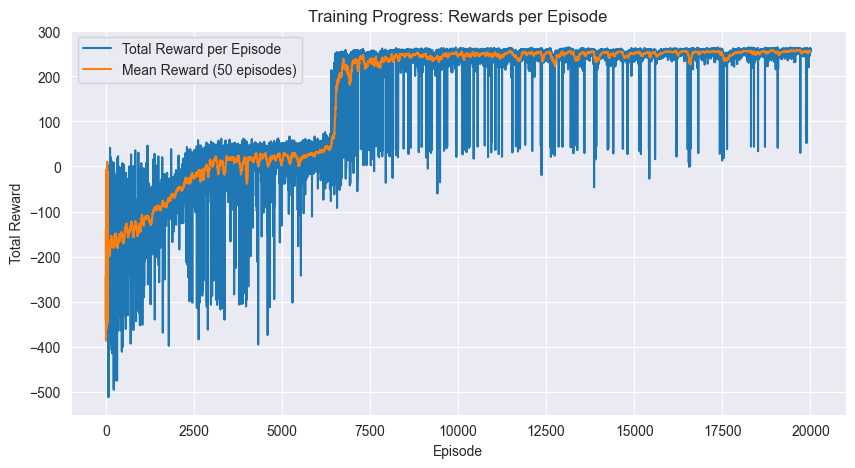

In [51]:
train_Agent()

In [29]:

# For plotting the animated video
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim



agent = A2CAgent(state_size=space_dim, action_size=action_dim)
state = env.reset()
done = False
score = 0 
agent.actor_nn.load_state_dict(torch.load('actor_nn_parameters.pth'))
agent.critic_nn.load_state_dict(torch.load('critic_nn_parameters.pth'))
# agent.local_nn.eval(
random.seed(None)  # Reset to default, random state
np.random.seed(None)

total_rewards = 0
mean_rewards = 0
frames = []
for eps in range(5):
    state = env.reset()
    score = 0
    done = False
    while not done:
        env.render()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        score += reward
        img = env.render(mode="rgb_array")
        frames.append(img)
        if done:
            print(score)
            break
    total_rewards += score
    mean_rewards = total_rewards / (eps + 1)
    print(f"Episode: {eps}, Score: {score}, Mean Rewards: {mean_rewards}")
#plot_animation(frames=frames)

    

AttributeError: 'A2CAgent' object has no attribute 'act'